In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
from sklearn.model_selection import train_test_split

# Desafio Feature Selection
Anteriormente utilizamos PCA con las mas de 90 variables que tenia nuestro dataset, no obstante, los resultado no mejoraron en comparacion a cuando utilizamos la correlacion con la variable dependiente, asi que esta vez haremos una combinacion de ambas cosas: aplicaremos PCA a las variables que mayor correlacion tiene con la variable dependiente.

In [3]:
CBP = pd.read_csv('https://media.githubusercontent.com/media/Gonzalo-Ariel-Alonso/Proyecto_Data_Science/master/Company%20Bankruptcy%20Prediction.csv')
CBP_filtered = CBP[['Bankrupt?',' Debt ratio %',' Current Liability to Assets',' Net Income to Total Assets',' ROA(A) before interest and % after tax',' Net worth/Assets',' Persistent EPS in the Last Four Seasons']]
CBP_filtered

,Bankrupt?,Debt ratio %,Current Liability to Assets,Net Income to Total Assets,ROA(A) before interest and % after tax,Net worth/Assets,Persistent EPS in the Last Four Seasons
0,1,0.207576,0.147308,0.716845,0.424389,0.792424,0.169141
1,1,0.171176,0.056963,0.795297,0.538214,0.828824,0.208944
2,1,0.207516,0.098162,0.774670,0.499019,0.792484,0.180581
3,1,0.151465,0.098715,0.739555,0.451265,0.848535,0.193722
4,1,0.106509,0.110195,0.795016,0.538432,0.893491,0.212537
...,...,...,...,...,...,...,...
6814,0,0.124618,0.103838,0.799927,0.539468,0.875382,0.216602
6815,0,0.099253,0.089901,0.799748,0.538269,0.900747,0.216697
6816,0,0.038939,0.024414,0.797778,0.533744,0.961061,0.210929
6817,0,0.086979,0.083199,0.811808,0.559911,0.913021,0.228326


In [4]:
# Division de variables dependientes e independientes
x = CBP_filtered.iloc[:,1:7]
y = CBP_filtered.iloc[:,0]

# Escalado de datos
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x, columns = list(x.columns))

Cantidad de componentes: 3
Varianza explicada total: % 98.06


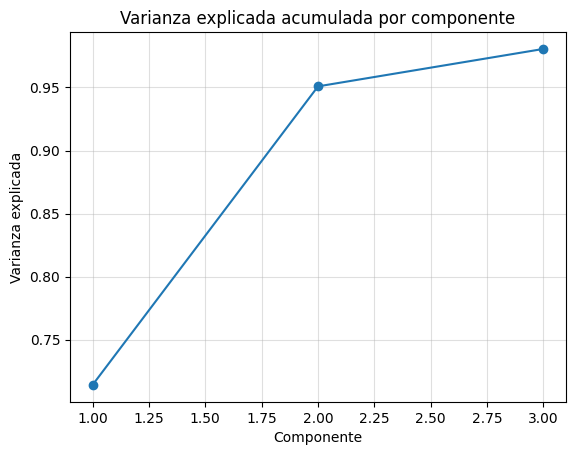

In [5]:
# Balanceo de variables
from imblearn.over_sampling import SMOTE
os = SMOTE()
x_os , y_os = os.fit_resample(x_scaled,y)


# Separacion de variables de entrenamiento y testeo
X_train, X_test , y_train , y_test = train_test_split(x_os , y_os ,test_size = 0.2)

# Calculo de numero de componentes optimo
cumulative_var_exp = 0
n_components = 1
while cumulative_var_exp < 0.97:
    n_components += 1
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    cumulative_var_exp = sum(pca.explained_variance_ratio_)


print('Cantidad de componentes:', n_components)
print('Varianza explicada total: %',round(cumulative_var_exp*100,2))

var_exp = pca.explained_variance_ratio_
cumulative_var_exp = np.cumsum(pca.explained_variance_ratio_)

# graficar la varianza explicada y acumulada
plt.plot(range(1, len(cumulative_var_exp)+1), cumulative_var_exp, marker='o')
plt.xlabel('Componente')
plt.ylabel('Varianza explicada')
plt.title('Varianza explicada acumulada por componente')
plt.grid(visible= True , axis='both',alpha=0.4)

In [6]:
# Aplicar PCA
pca = PCA(n_components=n_components)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)
pca.explained_variance_ratio_.sum()

0.9805840121698215

In [7]:
from sklearn.model_selection import GridSearchCV
# Hiperparametros
params = {
    'penalty':['l1', 'l2', 'elasticnet'],
    'C': [0.5,1.0,1.5,2.0],
    'intercept_scaling': [0.5,1.0,1.5],
    'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky','sag', 'saga'],
    'max_iter': [1000]
}

LR = LogisticRegression()

grid_logistic_regression = GridSearchCV(estimator = LR,
                                        param_grid = params,
                                        scoring = 'neg_mean_absolute_error',
                                        cv = 5,
                                        verbose = 1,
                                        n_jobs = -1,
)

In [8]:
%%time
grid_logistic_regression.fit(X_train,y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
CPU times: total: 844 ms
Wall time: 4.18 s


C:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
600 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    rai

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.5, 1.0, 1.5, 2.0],
                         'intercept_scaling': [0.5, 1.0, 1.5],
                         'max_iter': [1000],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='neg_mean_absolute_error', verbose=1)

In [9]:
grid_logistic_regression.best_params_

{'C': 2.0,
 'intercept_scaling': 1.0,
 'max_iter': 1000,
 'penalty': 'l2',
 'solver': 'sag'}

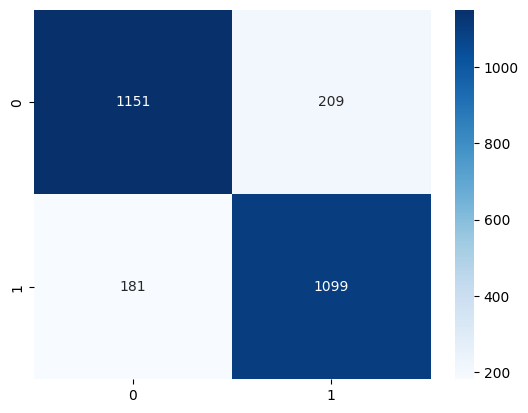

In [12]:
LR_best_params =  LogisticRegression(C= 2.0,
 intercept_scaling= 1.5,
 max_iter= 1000,
 penalty= 'l2',
 solver= 'sag')
LR_best_params.fit(X_train,y_train)

# Prediccion 2
y_pred_2 = LR_best_params.predict(X_test)

# Matriz de confucion
cm_2 = confusion_matrix(y_test, y_pred_2)
sns.heatmap(data = cm_2, annot = True,cmap='Blues', fmt='g')
plt.show()

In [13]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1360
           1       0.84      0.86      0.85      1280

    accuracy                           0.85      2640
   macro avg       0.85      0.85      0.85      2640
weighted avg       0.85      0.85      0.85      2640



# Conclusion 
Las metricas de clasificacion dieron mejores resutlados utilizando PCA en las variables con mayor correlacion a la variable dependiente que simplemente utilizar todas las variables del dataset. Sin embargo, si comparamos los resutlados de entrenar el algoritmo utilizando las variables con mayor correlacion y utilizando esas mismas variables procesadas por PCA, notamos que no existe diferencia alguna en los resultados.